***NASDAQ Predictions***

**DEV copy**

dataset is NASDAQ open and volume -  40 year history


**Imports**

In [2]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.gitvis_utils import plot_model
import pydot
from numpy import shape
import datetime
%load_ext tensorboard


**Global Variables**

In [3]:
MODEL_NUM=4
TRAINING_RATIO = .90
WINDOW_SIZE = 64
BATCH_SIZE = 1024
SHUFFLE_BUFFER = 1000
DATAFILE_CSV = 'd:/data/stocks/nasdaq1984.csv' # from https://finance.yahoo.com/quote/%5EIXIC/history/

**Describe the data**

In [4]:
def describe_datafile():
    with open(DATAFILE_CSV, 'r') as mydata:
        print("Header       :  {}".format(mydata.readline()))    
        print("First record :  {}".format(mydata.readline()))
        print("Second record:  {}".format(mydata.readline()))
    
describe_datafile()

Header       :  Date,Open,High,Low,Close,Adj Close,Volume

First record :  10/11/1984,244.199997,244.699997,244.199997,244.699997,244.699997,62860000

Second record:  10/12/1984,245.5,246.199997,245.5,246.199997,246.199997,58860000



**Parse the .csv data to numpy arrays and data dictionary**

In [5]:
def norm_close(close):
#     close=np.log(close)
#     close=close-7.5
#     close=close/2
    close=np.divide(close,15000.)
    close=close-.5

    return close    

def denorm_close(close):
#     close=close*2
#     close=close+7.5
#     close=np.exp(close)
    close=close+.5
    close=np.multiply(close,15000)

    return close



def parse_data_from_file(filename):
    
    dates = []
    close = []
    volume= []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
     
        for record in reader:                          # load file records into lists
            dates.append(record[0])
            close.append(float(record[4]))
            volume.append(float(record[6]))
        index=list(range(0,len(dates)))                 # create the index
        
        for datalist in [index, dates, close, volume]:   # turn them into numpy arrays
            datalist=np.array(datalist)
 
        # Log, Normalize and flip
        close=norm_close(close)
        volume=np.divide(volume,1e10)
        #datalist = np.flip(datalist))  

        return index, dates, close, volume
    


index, dates, close, volume = parse_data_from_file(DATAFILE_CSV)

dataarrays= [ index ,  dates ,  close ,  volume]
datanames=['index', 'dates', 'close', 'volume']
datadic={}    

for datum in enumerate(dataarrays):
    print('{:<6} {}'.format(datanames[datum[0]],np.shape(datum[1])))
    datadic[datanames[datum[0]]]=datum[1]

print('\ndatadic {}'.format(str(datadic.keys())))

index  (9611,)
dates  (9611,)
close  (9611,)
volume (9611,)

datadic dict_keys(['index', 'dates', 'close', 'volume'])


**Plot Processed Data**

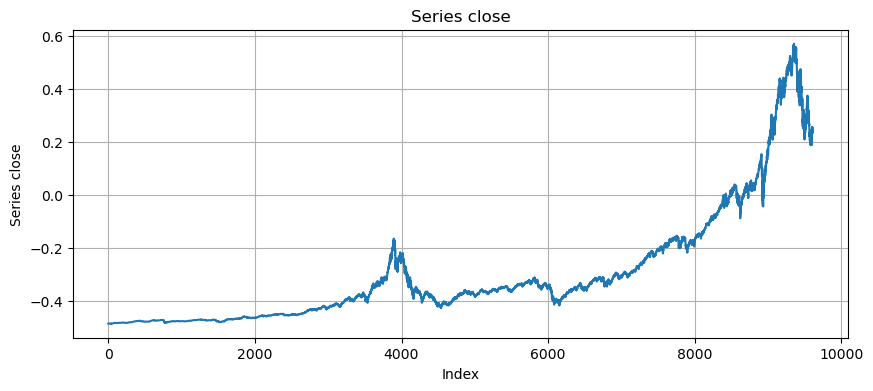

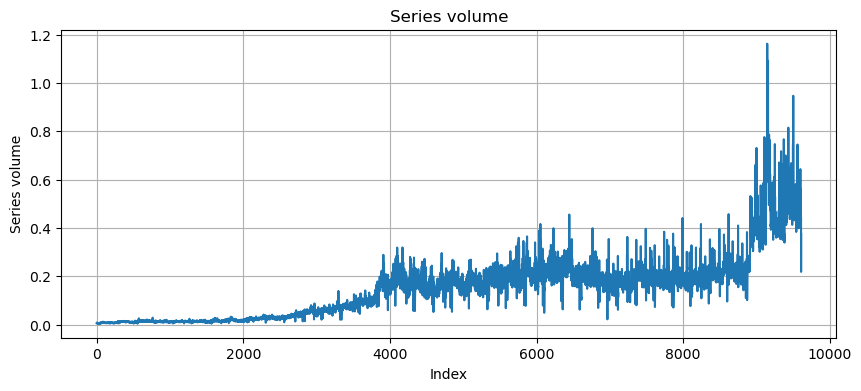

In [6]:
def plot_series(index, series, fignum=0,format="-", start=0, end=None):
            plt.figure(fignum, figsize=(10,4))
            plt.plot(index[start:end], series[start:end], format)
            plt.xlabel("Index")
            plt.ylabel("Series "+str(fignum))
            plt.grid(True)
            plt.title("Series "+str(fignum))

plot_series(index,close, 'close' )
plot_series(index,volume,'volume')

**Do Train and Validation splits**

In [7]:
def series_split(series, training_ratio=TRAINING_RATIO):
    first_validation=int(training_ratio*len(series))
    series_train = series[:first_validation]
    series_valid = series[first_validation:]
    
    return series_train, series_valid


# Split the datasets
datadic_train={}
datadic_val={}
print ('Default Training Ratio: {:.0f}%\n'.format(TRAINING_RATIO*100))

for datum in datadic:
    datadic_train[datum], datadic_val[datum] =series_split(datadic[datum])
    print('{:<8}  train shape: {}  validation shape: {}'.format(datum,shape(datadic_train[datum]), shape(datadic_val[datum])))#    datum, np.shape(datadic_train[datum]), np.shape(datadic_val[datum]) )

print ('\nOriginal series is {}'.format(np.shape(index)))
print('datadic_train: ',datadic_train.keys())
print('datadic_val  : ',datadic_val.keys())

Default Training Ratio: 90%

index     train shape: (8649,)  validation shape: (962,)
dates     train shape: (8649,)  validation shape: (962,)
close     train shape: (8649,)  validation shape: (962,)
volume    train shape: (8649,)  validation shape: (962,)

Original series is (9611,)
datadic_train:  dict_keys(['index', 'dates', 'close', 'volume'])
datadic_val  :  dict_keys(['index', 'dates', 'close', 'volume'])


**Create final data arrays**

In [8]:
data_all=np.stack((datadic['volume'],datadic['close']),axis=1)
data_train, data_val = series_split(data_all)

print('data_all  : ',np.shape(data_all))
print('data_train: ', np.shape(data_train))
print('data_val  : ', np.shape(data_val))


close_train, close_val = series_split(datadic['close'])
vol_train, vol_val = series_split(datadic['volume'])
index_train,index_val = series_split(index)

print('\nclose_train: ',np.shape(close_train))
print(  'vol_train  : ',np.shape(vol_train))


data_all  :  (9611, 2)
data_train:  (8649, 2)
data_val  :  (962, 2)

close_train:  (8649,)
vol_train  :  (8649,)


***Create windowed dataset***

In [10]:
def windowed_dataset_multi(series1, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER, shuffle=1, verbose=0):
    
    ds = tf.data.Dataset.from_tensor_slices(series1)
    if verbose==1:
        for elem in ds:
            print('created tensor: ')
            print('   ds elem:', elem)
            print('   ds elem[0]:',elem[0])
            print('   ds elem[1]:',elem[1])
            break
    
    #if shuffle==1: ds = ds.shuffle(shuffle_buffer)  
    
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)  # +1 is the label
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1,1]))  # maps inputs and label
     
    if verbose==1:
        print('\nAfter batch map:')
        for elem in ds:
             print('   ds elem:', np.shape(elem))
             print('   ds elem[0][0] :',shape(elem[0]),elem[0][0])
             print('   ds elem[0][-1]:',shape(elem[0]),elem[0][-1])
             print('   ds elem[1]:',shape(elem[1]),elem[1])
             break
        
    ds = ds.batch(batch_size).prefetch(1)
    
    if verbose==1:
        print('\nAfter creating batches:')
        for elem in ds:
            print('   ds elem[0]:',shape(elem[0]))
            print('   ds elem[1]:',shape(elem[1]),elem[1][63],'\n')
            break
    
    return ds

# Apply the transformation to the training set

print('sending data_train: ',shape(data_train), type(data_train)) 
print('   data_train[0,0]',data_train[0,0])
print('   data_train[0,1]',data_train[0,1],'\n')

train_set  = windowed_dataset_multi(data_train, window_size=64, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER, verbose=1,shuffle=1)
val_set  = windowed_dataset_multi(data_val, window_size=64, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER, shuffle=0)


sending data_train:  (8649, 2) <class 'numpy.ndarray'>
   data_train[0,0] 0.006286
   data_train[0,1] -0.48368666686666667 

created tensor: 
   ds elem: tf.Tensor([ 0.006286   -0.48368667], shape=(2,), dtype=float64)
   ds elem[0]: tf.Tensor(0.006286, shape=(), dtype=float64)
   ds elem[1]: tf.Tensor(-0.48368666686666667, shape=(), dtype=float64)

After batch map:
   ds elem: (2,)
   ds elem[0][0] : (64, 2) tf.Tensor([ 0.006286   -0.48368667], shape=(2,), dtype=float64)
   ds elem[0][-1]: (64, 2) tf.Tensor([ 0.007152   -0.48318667], shape=(2,), dtype=float64)
   ds elem[1]: () tf.Tensor(-0.48296666666666666, shape=(), dtype=float64)

After creating batches:
   ds elem[0]: (1024, 64, 2)
   ds elem[1]: (1024,) tf.Tensor(-0.4812599996, shape=(), dtype=float64) 



In [11]:
for elem in train_set:
    print('last close in window: ',denorm_close(elem[0][-1,-1,1]))  # [inputs][batch, window, volume]
    print('label for next close: ',denorm_close(elem[1][-1]))       # [labels][batch, window, close ]
    print('percent change: {:+3.2}%'.format(float(elem[0][-1,-1,1])/float(elem[1][-1])*100-100))
    print('\n')
    break
    

last close in window:  399.200012
label for next close:  401.2999880000001
percent change: +0.03%




**Define the model**

In [60]:
def best_model():

        # inputs
        input_layer=tf.keras.Input(shape=(WINDOW_SIZE,2))  #both
        x=input_layer[:,:,1]       # batch, window, close
        y=input_layer[:,-32:,0]    # batch, window, volume
        w=input_layer[:,-16:,:]    # batch, window, vol&close
        s1=input_layer[:,-1,1]     # batch, last value, close
        
        # close lstms
        x=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None], name ='CLOSE')(x)
        x=tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh', name='Close1')(x)
        x=tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh', name='Close2')(x)
        x=tf.keras.layers.LSTM(128, name='Close3')(x)
        x=tf.keras.layers.Dense(128)(x)
        x=tf.keras.layers.Dense(64)(x)
        
        # volume convolutions
        y=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None],name='VOLUME')(y)
        y=tf.keras.layers.Conv1D(filters=16, kernel_size=7, strides=1, padding='same', activation='relu')(y)
        y=tf.keras.layers.Flatten(name='Volume0')(y)
        y=tf.keras.layers.Dense(64, name='Volume1')(y)
        y=tf.keras.layers.Dense(64, name='Volume2')(y)

        # close and volume convolutions
        w=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None], name='CLOSE_VOLUME')(w)
        w=tf.keras.layers.Conv2D(filters=16, kernel_size=(3,2), strides=1, padding='same', activation='relu', name='Both1')(w)
        w=tf.math.reduce_max(w,axis=2)
        w=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh', name='Both2'))(w)
        w=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh'))(w)
        w=tf.keras.layers.Flatten()(w)
        w=tf.keras.layers.Dense(64)(w)
        w=tf.keras.layers.Dense(64)(w)
        
        # skip route
        s1=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None], name='LAST_CLOSE')(s1)        
        
        # master DNN        
        z=tf.keras.layers.Concatenate(axis=1,)([x,y,w,s1])     
        z=tf.keras.layers.Dense(128)(z)
        z=tf.keras.layers.Dense(64)(z)
        z=tf.keras.layers.Dense(32)(z)
        z=tf.keras.layers.Dense(16)(z)
        z=tf.keras.layers.Concatenate(axis=1,)([z,s1])
        
        # output
        output_layer=tf.keras.layers.Dense(1)(z)       
        model = Model(inputs=input_layer, outputs=output_layer)
    
        return model

In [70]:
def test_model():  

         # inputs
        input_layer=tf.keras.Input(shape=(WINDOW_SIZE,2))  #both
        x=input_layer[:,:,1]       # batch, window, close
        y=input_layer[:,-32:,0]    # batch, window, volume
        w=input_layer[:,-16:,:]    # batch, window, vol&close
        s1=input_layer[:,-3:,1]     # batch, last value, close
        
        # close lstms
        x=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None], name ='CLOSE')(x)
        x=tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh', name='Close1')(x)
        x=tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh', name='Close2')(x)
        x=tf.keras.layers.LSTM(128, name='Close3')(x)
        x=tf.keras.layers.Dense(128)(x)
        x=tf.keras.layers.Dense(64)(x)
        
        # volume convolutions
        y=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None],name='VOLUME')(y)
        y=tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same', activation='relu')(y)
        y=tf.keras.layers.Flatten(name='Volume0')(y)
        y=tf.keras.layers.Dense(64, name='Volume1')(y)
        y=tf.keras.layers.Dense(64, name='Volume2')(y)

        # close and volume convolutions
        w=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None], name='CLOSE_VOLUME')(w)
        w=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,2), strides=1, padding='same', activation='relu', name='Both1')(w)
        w=tf.math.reduce_max(w,axis=2)
        w=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh', name='Both2'))(w)
        w=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh'))(w)
        w=tf.keras.layers.Flatten()(w)
        w=tf.keras.layers.Dense(128)(w)
        w=tf.keras.layers.Dense(64)(w)
        
        # last close skip route
        #s1=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None], name='LAST_CLOSE')(s1)        
        
        # master DNN        
        z=tf.keras.layers.Concatenate(axis=1,)([x,y,w,s1])     
        z=tf.keras.layers.Dense(128)(z)
        z=tf.keras.layers.Dense(128)(z)
        z=tf.keras.layers.Dense(64)(z)
        z=tf.keras.layers.Dense(64)(z)
        z=tf.keras.layers.Concatenate(axis=1,)([z,s1])
        
        # output
        output_layer=tf.keras.layers.Dense(1)(z)       
        model = Model(inputs=input_layer, outputs=output_layer)
    
        return model

In [69]:
tuning_model=test_model()

tuning_model.summary()
print('predictions returned: ',shape(tuning_model.predict(train_set)))

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64, 2)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_42 (Sl (None, 16, 2)        0           input_11[0][0]                   
__________________________________________________________________________________________________
CLOSE_VOLUME (Lambda)           (None, 16, 2, 1)     0           tf.__operators__.getitem_42[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_40 (Sl (None, 64)           0           input_11[0][0]                   
____________________________________________________________________________________________

**Try a range of learning rates** 

In [17]:
def try_learning_rates(model, dataset):
    
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    stop_callback = tf.keras.callbacks.EarlyStopping(patience=20, monitor='mae', verbose=1, mode='min', restore_best_weights=True)
    callbacks=[lr_schedule, stop_callback]
    #optimizer=tf.keras.optimizers.Adam(learning_rate=5.e-5 )
    optimizer=tf.keras.optimizers.SGD (learning_rate=5.e-5, momentum=.9) 
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    history = model.fit(train_set, epochs=100, callbacks=callbacks)
    
    return history

# Train in a range of learning rates


tuning_model=test_model() 
lr_history = try_learning_rates(tuning_model,train_set)


Epoch 1/100
9/9 [==============================] - 10s 122ms/step - loss: 0.0625 - mae: 0.3245
Epoch 2/100
9/9 [==============================] - 1s 116ms/step - loss: 0.0477 - mae: 0.2776
Epoch 3/100
9/9 [==============================] - 1s 118ms/step - loss: 0.0321 - mae: 0.2233
Epoch 4/100
9/9 [==============================] - 1s 116ms/step - loss: 0.0210 - mae: 0.1768
Epoch 5/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0149 - mae: 0.1433
Epoch 6/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0121 - mae: 0.1259
Epoch 7/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0108 - mae: 0.1178
Epoch 8/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0101 - mae: 0.1137
Epoch 9/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0097 - mae: 0.1113
Epoch 10/100
9/9 [==============================] - 1s 116ms/step - loss: 0.0095 - mae: 0.1100
Epoch 11/100
9/9 [==============================] - 1s 117

**Review results and set optimized learning rate**

dict_keys(['loss', 'mae', 'lr'])


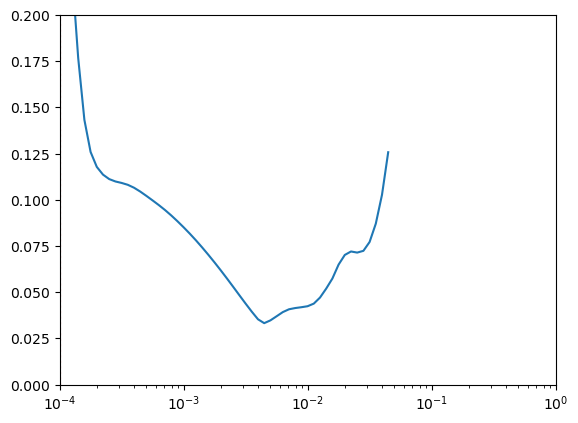

In [40]:
LEARNING_RATE=1e-4              ##  This sets learning rate for the model below  ##
print(lr_history.history.keys())
plt.semilogx(lr_history.history["lr"], lr_history.history["mae"])
plt.axis([1e-4,1, 0, .2])
plt.axvline(x = LEARNING_RATE, color = 'r' ,linestyle='dotted')
plt.show()

**Create the training model**

In [52]:
model=test_model()
print('predictions returned: ',shape(tuning_model.predict(train_set)))

predictions returned:  (8585, 1)


**Review model**

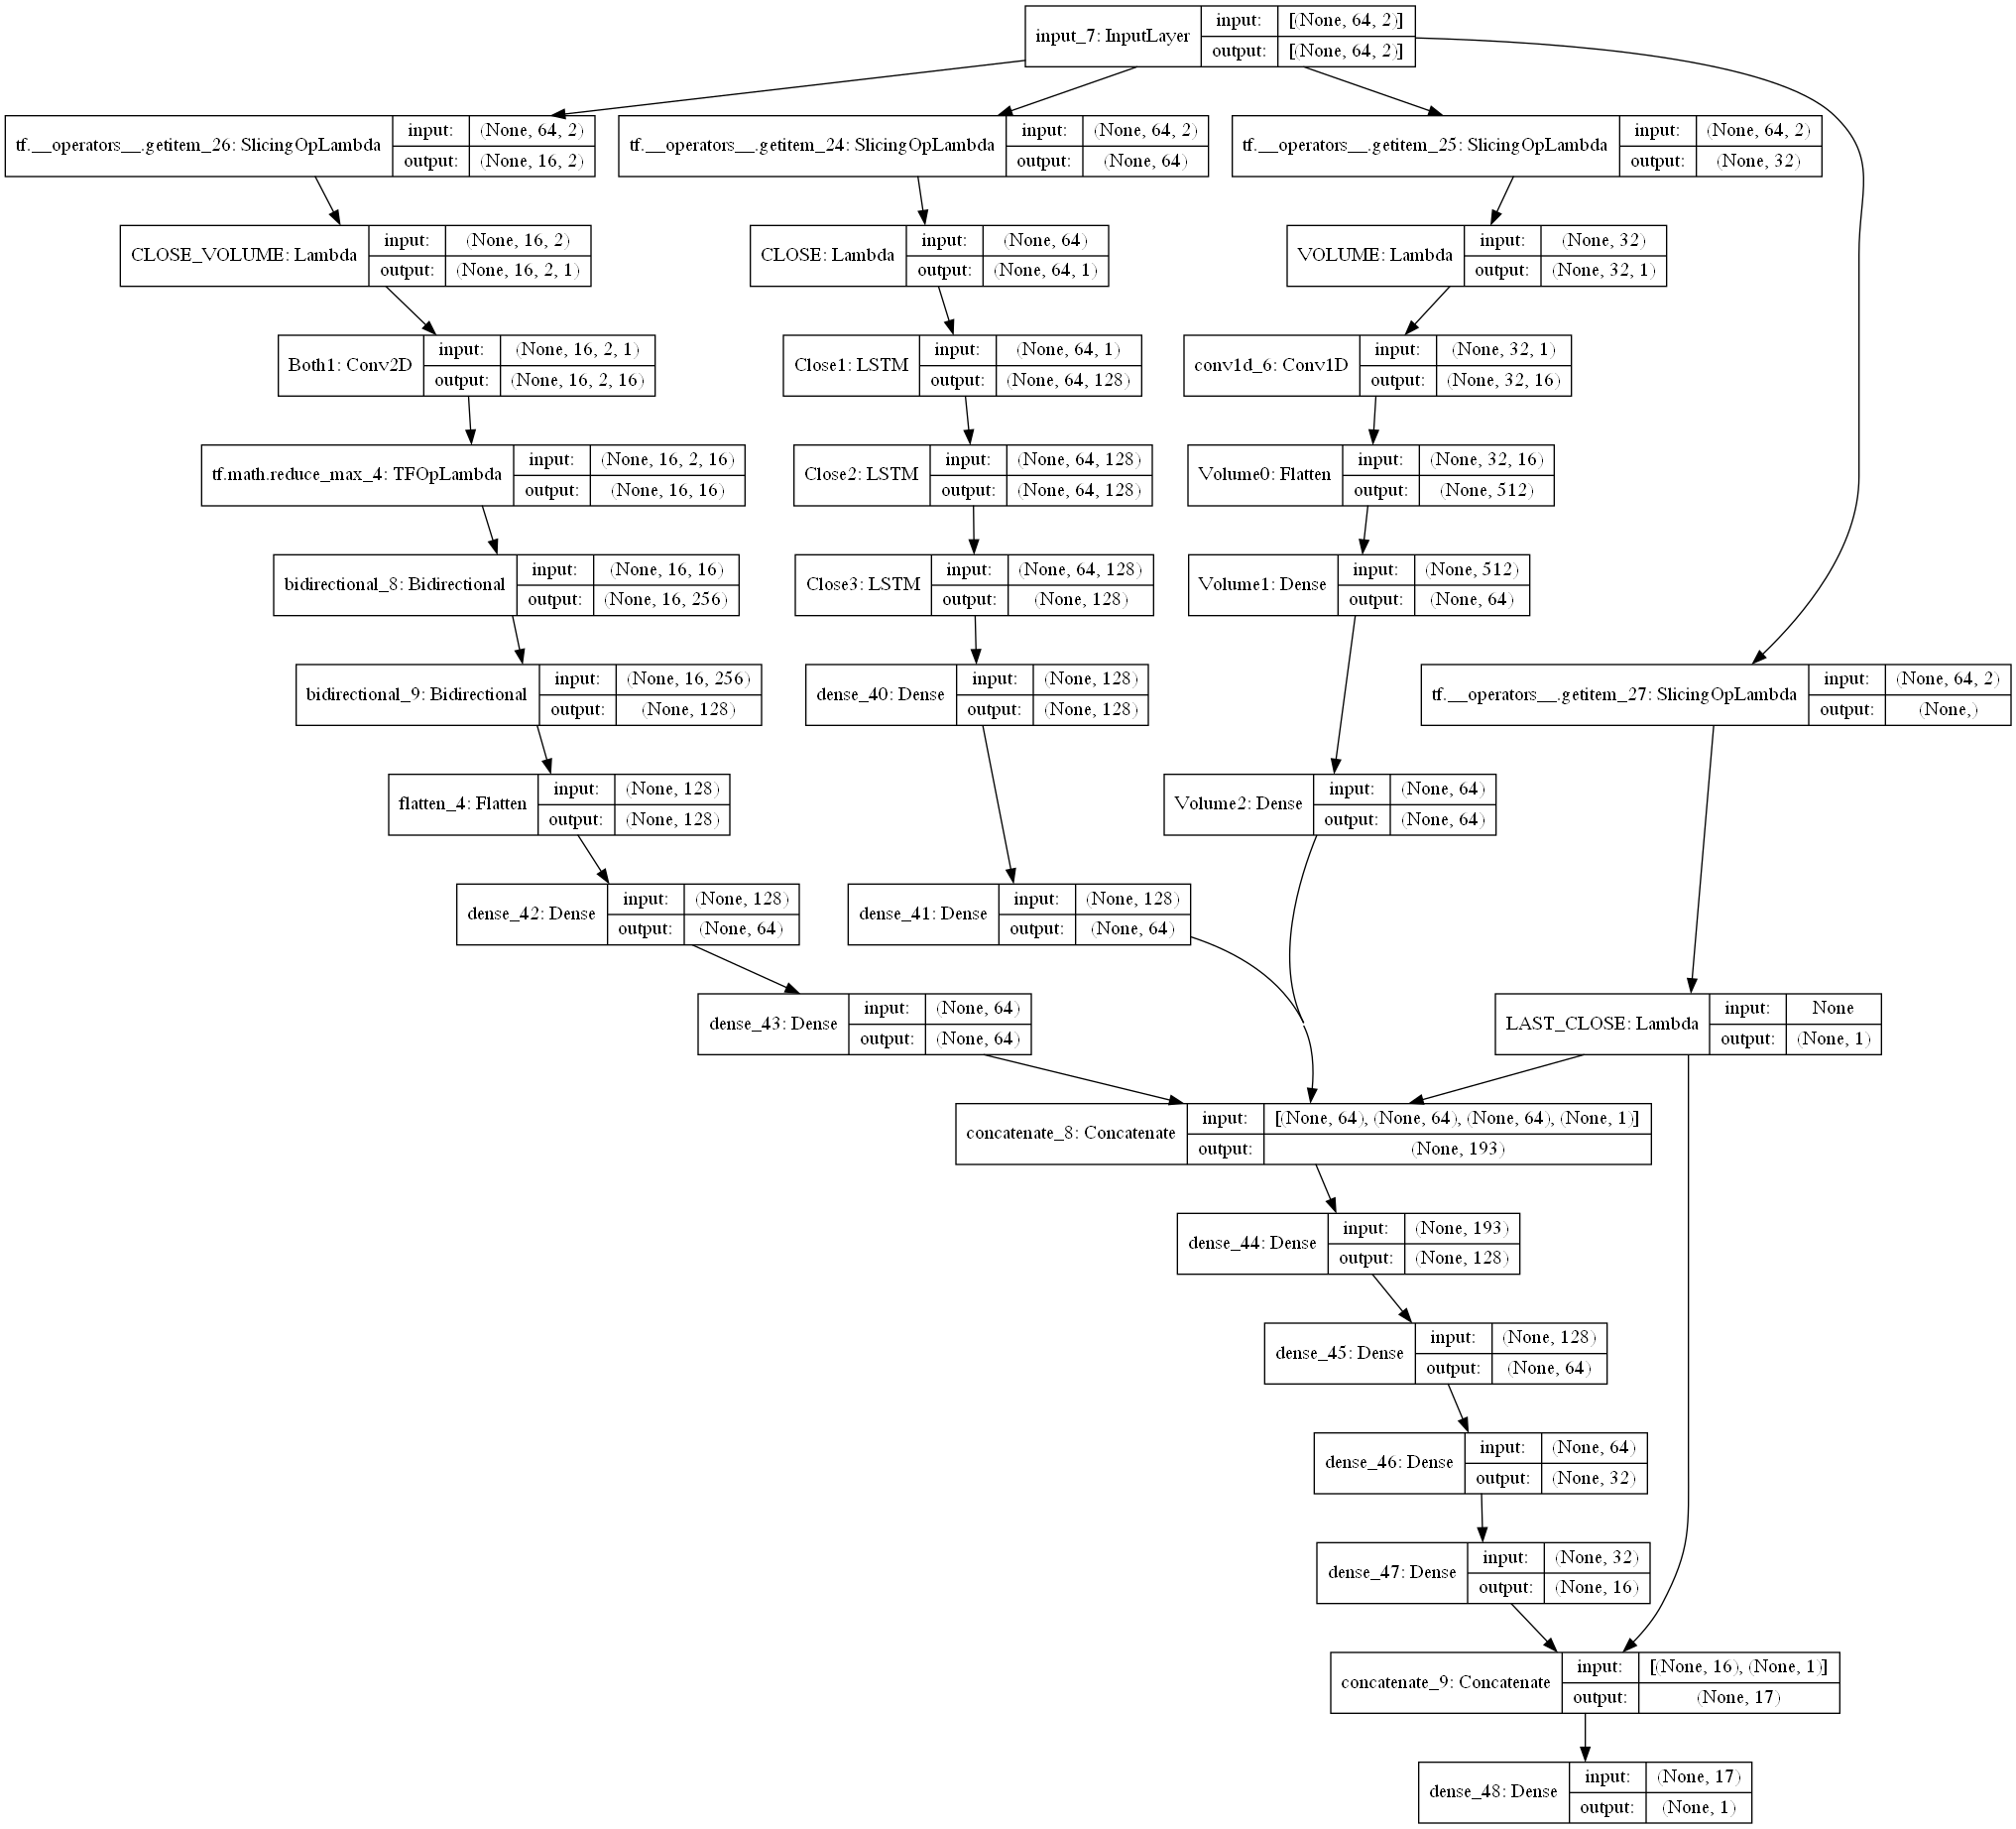

In [63]:
plot_model(model , to_file="nasdaq.png" , show_shapes= True , show_layer_names=True)
#model.summary()

**Save and load model**

In [53]:
# Save model to HDF5 file

#model.save('model992',save_format="h5")
#model.save_weights('weights992')
model.load_weights('weights992')

**Callbacks, optimize, compile**

In [55]:
#callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard('tensorboard')
stop_callback = tf.keras.callbacks.EarlyStopping(patience=200, monitor='val_mae', verbose=1, mode='min', restore_best_weights=True)
lr_callback=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.9, verbose=1, patience=100, min_delta=.000001, min_lr=1e-6),
callbacks=[lr_callback, stop_callback]


#optimize & compile
#optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE )
optimizer=tf.keras.optimizers.SGD (learning_rate=LEARNING_RATE, momentum=.9) 

#model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"]) 
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer, metrics=["mae"]) 

**Train**

In [43]:
#train
history =  model.fit(train_set, epochs=5000, callbacks=callbacks, verbose=1, validation_data=val_set)

Epoch 1/5000
9/9 [==============================] - 12s 347ms/step - loss: 3.6779e-05 - mae: 0.0055 - val_loss: 1.5820e-04 - val_mae: 0.0090
Epoch 2/5000
9/9 [==============================] - 1s 133ms/step - loss: 3.3911e-05 - mae: 0.0052 - val_loss: 1.5808e-04 - val_mae: 0.0090
Epoch 3/5000
9/9 [==============================] - 1s 134ms/step - loss: 3.0211e-05 - mae: 0.0049 - val_loss: 1.5797e-04 - val_mae: 0.0090
Epoch 4/5000
9/9 [==============================] - 1s 132ms/step - loss: 2.6622e-05 - mae: 0.0045 - val_loss: 1.5789e-04 - val_mae: 0.0090
Epoch 5/5000
9/9 [==============================] - 1s 132ms/step - loss: 2.3450e-05 - mae: 0.0042 - val_loss: 1.5783e-04 - val_mae: 0.0090
Epoch 6/5000
9/9 [==============================] - 1s 133ms/step - loss: 2.0754e-05 - mae: 0.0039 - val_loss: 1.5781e-04 - val_mae: 0.0090
Epoch 7/5000
9/9 [==============================] - 1s 132ms/step - loss: 1.8500e-05 - mae: 0.0037 - val_loss: 1.5781e-04 - val_mae: 0.0090
Epoch 8/5000
9/9 [=

9/9 [==============================] - 1s 132ms/step - loss: 7.4011e-06 - mae: 0.0019 - val_loss: 1.6118e-04 - val_mae: 0.0091
Epoch 60/5000
9/9 [==============================] - 1s 132ms/step - loss: 7.3944e-06 - mae: 0.0019 - val_loss: 1.6126e-04 - val_mae: 0.0091
Epoch 61/5000
9/9 [==============================] - 1s 132ms/step - loss: 7.3878e-06 - mae: 0.0019 - val_loss: 1.6133e-04 - val_mae: 0.0091
Epoch 62/5000
9/9 [==============================] - 1s 132ms/step - loss: 7.3813e-06 - mae: 0.0019 - val_loss: 1.6141e-04 - val_mae: 0.0091
Epoch 63/5000
9/9 [==============================] - 1s 132ms/step - loss: 7.3749e-06 - mae: 0.0019 - val_loss: 1.6148e-04 - val_mae: 0.0091
Epoch 64/5000
9/9 [==============================] - 1s 133ms/step - loss: 7.3687e-06 - mae: 0.0019 - val_loss: 1.6156e-04 - val_mae: 0.0091
Epoch 65/5000
9/9 [==============================] - 1s 131ms/step - loss: 7.3625e-06 - mae: 0.0019 - val_loss: 1.6164e-04 - val_mae: 0.0091
Epoch 66/5000
9/9 [========

9/9 [==============================] - 1s 131ms/step - loss: 7.1245e-06 - mae: 0.0018 - val_loss: 1.6567e-04 - val_mae: 0.0092
Epoch 117/5000
9/9 [==============================] - 1s 132ms/step - loss: 7.1212e-06 - mae: 0.0018 - val_loss: 1.6574e-04 - val_mae: 0.0092
Epoch 118/5000
9/9 [==============================] - 1s 132ms/step - loss: 7.1178e-06 - mae: 0.0018 - val_loss: 1.6582e-04 - val_mae: 0.0092
Epoch 119/5000
9/9 [==============================] - 1s 132ms/step - loss: 7.1146e-06 - mae: 0.0018 - val_loss: 1.6589e-04 - val_mae: 0.0092
Epoch 120/5000
9/9 [==============================] - 1s 135ms/step - loss: 7.1113e-06 - mae: 0.0018 - val_loss: 1.6597e-04 - val_mae: 0.0092
Epoch 121/5000
9/9 [==============================] - 1s 132ms/step - loss: 7.1081e-06 - mae: 0.0018 - val_loss: 1.6604e-04 - val_mae: 0.0092
Epoch 122/5000
9/9 [==============================] - 1s 133ms/step - loss: 7.1049e-06 - mae: 0.0018 - val_loss: 1.6611e-04 - val_mae: 0.0092
Epoch 123/5000
9/9 [=

Epoch 174/5000
9/9 [==============================] - 1s 134ms/step - loss: 6.9714e-06 - mae: 0.0018 - val_loss: 1.6984e-04 - val_mae: 0.0093
Epoch 175/5000
9/9 [==============================] - 1s 132ms/step - loss: 6.9693e-06 - mae: 0.0018 - val_loss: 1.6990e-04 - val_mae: 0.0093
Epoch 176/5000
9/9 [==============================] - 1s 133ms/step - loss: 6.9672e-06 - mae: 0.0018 - val_loss: 1.6997e-04 - val_mae: 0.0093
Epoch 177/5000
9/9 [==============================] - 1s 132ms/step - loss: 6.9653e-06 - mae: 0.0018 - val_loss: 1.7004e-04 - val_mae: 0.0093
Epoch 178/5000
9/9 [==============================] - 1s 132ms/step - loss: 6.9632e-06 - mae: 0.0018 - val_loss: 1.7011e-04 - val_mae: 0.0093
Epoch 179/5000
9/9 [==============================] - 1s 134ms/step - loss: 6.9613e-06 - mae: 0.0018 - val_loss: 1.7018e-04 - val_mae: 0.0093
Epoch 180/5000
9/9 [==============================] - 1s 132ms/step - loss: 6.9593e-06 - mae: 0.0018 - val_loss: 1.7024e-04 - val_mae: 0.0093
Epoch 

**Review training results**

History: dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


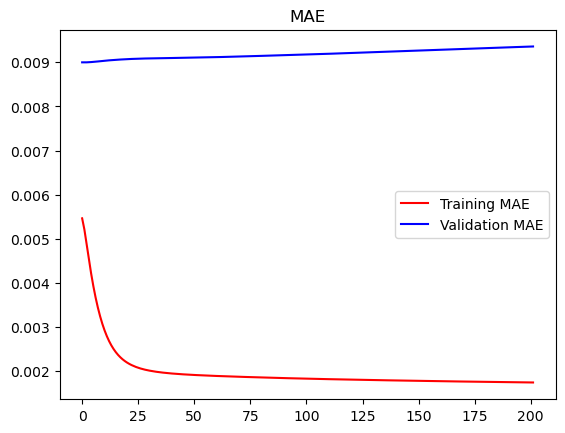

1/1 [==============================] - 0s 145ms/step - loss: 1.5808e-04 - mae: 0.0090


[0.00015808279567863792, 0.008997278288006783]

In [56]:
print("History: {}".format(history.history.keys()))

acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, mae, 'r', label="Training MAE")
plt.plot(epochs, val_mae, 'b', label="Validation MAE")
plt.title('MAE')
plt.legend(loc=0)
plt.show()
model.evaluate(train_set)
model.evaluate(val_set)

**Evaluate the forecast**

**Run predictions**

In [57]:
# Compute the forecast for validation
forecast = model.predict(val_set).squeeze()

In [145]:
#%tensorboard --logdir=tensorboard

**Review Results**

As of              : 11/28/2022
Yesterday forecast : 11,316
Today's close      : 11,049
Percent error      : 2.41%
Tomorrow's forecast: 11,257


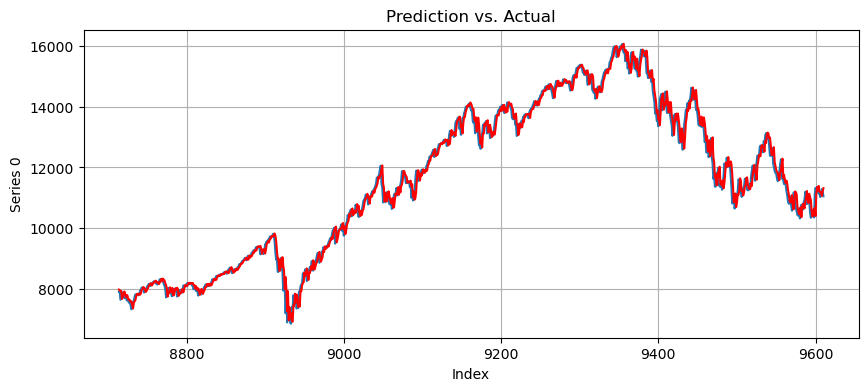

In [58]:
label_val=data_val[WINDOW_SIZE:,1]  # labels start at first value plus window
last=denorm_close(forecast[-1])
yesterday=denorm_close(forecast[-2])
true=denorm_close(label_val[-1])
print ('As of              : {}'.format(dates[-1]))
print ('Yesterday forecast : {:,.0f}'.format(yesterday))
print ("Today's close      : {:,.0f}".format(true))
print ('Percent error      : {:.2f}%'.format((yesterday-true)*100/true))
print ("Tomorrow's forecast: {:,.0f}".format(last))

# Plot forecast vs. actual
plot_series(index_val[WINDOW_SIZE+1:], denorm_close(label_val[1:]))
plot_series(index_val[WINDOW_SIZE+1:], denorm_close(forecast[:-1]),format='r')
plt.title('Prediction vs. Actual')
plt.show()

In [329]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

mse, mae = compute_metrics(close_val[WINDOW_SIZE:], forecast.reshape(-1))

print("Forecast vs. labels: mse: {:.5f}, mae: {:.4f}".format(mse,mae))


Forecast vs. labels: mse: 0.00016, mae: 0.0094


**Make Prediction**

In [330]:
last_close=denorm_close(data_val[-1,1])

tomorrow_forecast=denorm_close(forecast[-1])
gain_points=tomorrow_forecast-last_close
percent=gain_points/last_close*100.
print("as of                 {}:".format(dates[-1]))
print("today's close       : {:,.0f}".format(last_close))
print("tomorrow's forecast : {:,.0f}".format(tomorrow_forecast))
print("predicted gain of: {:.2f} points or {:.2f}%\n".format(gain_points,percent))

as of                 11/28/2022:
today's close       : 11,049
tomorrow's forecast : 11,285
predicted gain of: 235.79 points or 2.13%



**Run trading simulation**

In [360]:
all_in=False
cash=10000.
shares=0
forecast_dates=datadic_val['dates'][WINDOW_SIZE:]
close_actual = denorm_close(close_val[WINDOW_SIZE:])  # actual results from next day to compare to prediction 
forecast_actual = denorm_close(forecast)
days_correct=0
days_incorrect=0

for i in range(1,len(forecast_actual)-1):    # can't use last because no true label
    buyhold=10000.*close_actual[i]/close_actual[1]
    if close_actual[i+1]>close_actual[i] and shares==0: 
        error='Should be invested'
        days_incorrect+=1
    elif close_actual[i+1]<close_actual[i] and cash==0:
        error='Should be cash'
        days_incorrect+=1
    else: 
        error='Correct'
        days_correct+=1
    print('date: {}   Close: {:,.0f}  Forecast: {:,.0f}  Cash:{:,.0f}  Shares:{:,.2f} Total:{:,.0f} BH:{:,.2f}  {}'.format(\
        forecast_dates[i],close_actual[i], forecast_actual[i],cash,shares,\
        cash+shares*close_actual[i], buyhold,error ))
    
    if  forecast_actual[i]>close_actual[i-1] and all_in is False:
        all_in =True
        shares=cash/close_actual[i-1]
        cash=0
        print ('buying {:.2f} shares at {:,.0f}'.format(shares,close_actual[i]))
        
    if forecast_actual[i]<close_actual[i-1] and all_in is True:
        print ('selling {:.2f} shares at {:,.0f}'.format(shares,close_actual[i]))
        all_in = False
        cash=shares*close_actual[i-1]
        shares=0
    
wealth_ai=cash+shares*close_actual[-1] 
wealth_bh=10000*close_actual[-1]/close_actual[1]
return_ai=wealth_ai-10000
return_bh=wealth_bh-10000
print('\ndays correct: {}       days incorrect: {}'.format(days_correct, days_incorrect) )
print('total wealth: ${:,.0f}   total with B&H: ${:,.0f}'.format(wealth_ai,wealth_bh))
print('total gains : ${:,.0f}    gains with B&H: ${:,.0f}'.format(return_ai, return_bh))
print('\nPercent improvement: {:.2f}%'.format(100*(return_ai-return_bh)/return_bh))


date: 5/9/2019   Close: 7,911  Forecast: 7,950  Cash:10,000  Shares:0.00 Total:10,000 BH:10,000.00  Should be invested
buying 1.26 shares at 7,911
date: 5/10/2019   Close: 7,917  Forecast: 7,905  Cash:0  Shares:1.26 Total:9,967 BH:10,008.03  Should be cash
selling 1.26 shares at 7,917
date: 5/13/2019   Close: 7,647  Forecast: 7,920  Cash:9,959  Shares:0.00 Total:9,959 BH:9,666.81  Should be invested
buying 1.26 shares at 7,647
date: 5/14/2019   Close: 7,734  Forecast: 7,657  Cash:0  Shares:1.26 Total:9,729 BH:9,777.39  Correct
date: 5/15/2019   Close: 7,822  Forecast: 7,752  Cash:0  Shares:1.26 Total:9,840 BH:9,888.20  Correct
date: 5/16/2019   Close: 7,898  Forecast: 7,838  Cash:0  Shares:1.26 Total:9,935 BH:9,984.15  Should be cash
date: 5/17/2019   Close: 7,816  Forecast: 7,897  Cash:0  Shares:1.26 Total:9,832 BH:9,880.78  Should be cash
selling 1.26 shares at 7,816
date: 5/20/2019   Close: 7,702  Forecast: 7,817  Cash:9,935  Shares:0.00 Total:9,935 BH:9,736.80  Should be invested
b